In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import roc_curve, auc

In [122]:
original_df = pd.read_csv('default of credit card clients.csv')
data = original_df.copy()

## Data Cleaning and Preparation



### Data cleaning
*By Davis Johnson*

An intial view of the dataset suggests that:

1. The columns have been loaded in as the first row of the dataset and in capitalized letters. Both need to be fixed in order to help with the data's readability. Additionally, some columns needed to be renamed for clarity purposes. This mostly included renaming columns to include the month they were associated with.

2. An analysis of the values for the categorical columns (like education and marriage) revealed they contained some values not associated with any lables in the dataset description. For example, the marriage columns had some values that recorded as 5 or 6 even though such numbers had no significance. Any such values were replaced with the number corresponding to the "other" columns.

3. Additionally, being that the sex, marriage, and age columns are all categorical features - we decided to create dummy variables for each of their features.

The code below implements the above cleaning.

In [123]:
#Fixing Column Headings
data= data.set_axis(data.iloc[0], axis=1)
data = data.drop(data.index[0])

In [124]:
## Dropping ID since it will not be used in the analysis
data.drop(columns=['ID'], inplace=True)

In [125]:
## Making Columns Lowercase
data.columns = data.columns.str.lower()

In [126]:
## Renaming Columns for Clarity
new_names = {'pay_0': 'repay_status_sept', 'pay_2': 'repay_status_aug', 'pay_3': 'repay_status_jul', 
             'pay_4': 'repay_status_jun', 'pay_5': 'repay_status_may', 'pay_6': 'repay_status_apr',
            'bill_amt1': 'bill_sept', 'bill_amt2': 'bill_aug', 'bill_amt3': 'bill_jul', 'bill_amt4': 'bill_jun',
            'bill_amt5': 'bill_may', 'bill_amt6': 'bill_apr', 'pay_amt1': 'pay_amt_sept', 'pay_amt2': 'pay_amt_aug',
            'pay_amt3': 'pay_amt_jul', 'pay_amt4': 'pay_amt_jun', 'pay_amt5': 'pay_amt_may', 'pay_amt6': 'pay_amt_apr',
            'default payment next month': 'defaulted'}
data.rename(columns=new_names, inplace=True)

In [127]:
## Converting Columns from Object to Numeric:
# Iterate over the columns in the DataFrame
for column in data.columns:
    # Check if the column can be converted to a float
    if data[column].str.contains('\.').any():
        # If the column contains decimal points, convert it to a float
        data[column] = data[column].astype(float)
    else:
        # If the column does not contain decimal points, convert it to an integer
        data[column] = data[column].astype(int)

In [128]:
## Copying dataset to retain progress
X = data.copy()

In [129]:
## Combining Education Values 0, 5, and 6 to 4 which is classified as other
## 0,5,6 are not mentioned in dataset description
X['education'] = X['education'].replace({5: 4, 6: 4, 0: 4})

In [130]:
## Combining Marriage Value 0 with 3 which is classified as other
## 0 is not mentioned as a value in the dataset description that relates to a marriage category
X['marriage'] = X['marriage'].replace({0: 3})

In [131]:
## Encoding education, marriage, and sex since they are unordered nominal features
education_onehot = pd.get_dummies(X['education'], prefix='education')

# Rename the education columns with the corresponding education levels
education_levels = {
    'education_1': 'graduate_school',
    'education_2': 'university',
    'education_3': 'high_school',
    'education_4': 'others_education'
}
education_onehot = education_onehot.rename(columns=education_levels)

# Concatenate the one-hot encoded columns with the original DataFrame
X = pd.concat([X, education_onehot], axis=1)

# Remove the original "education" column
X = X.drop(['education'], axis=1)

marriage_onehot = pd.get_dummies(X['marriage'], prefix='marriage')

# Rename the marriage columns with the corresponding marital statuses
marital_statuses = {
    'marriage_1': 'married',
    'marriage_2': 'single',
    'marriage_3': 'others_married'
}
marriage_onehot = marriage_onehot.rename(columns=marital_statuses)

# Concatenate the one-hot encoded columns with the original DataFrame
X = pd.concat([X, marriage_onehot], axis=1)

# Remove the original "marriage" column
X = X.drop(['marriage'], axis=1)

sex_onehot = pd.get_dummies(X['sex'],prefix='sex')
sex_status = {
    'sex_1': 'sex_male',
    'sex_2': 'sex_female'
}
sex_onehot = sex_onehot.rename(columns=sex_status)
X = pd.concat([X, sex_onehot], axis=1)
X = X.drop(['sex'],axis=1)

### Data preparation
*Davis Johnson*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we will be conducting stepwise selection, one dummy level of each categorical variable was dropped to avoid issues of perfect collinearity. 

2. Since the "bill_month" columns have problematic VIF values, we decided to conduct some feature enginnering by creating a new predicot called "avg_bill_per_month" which represents the average credit card bill of each person over this six month time span. The individual "bill_month" columns were then dropped.

3. We split the dataset into a training set and testing set.

4. We have created a standardized version of the test/train datasets, as we will use it to develop Lasso regression models.

In [132]:
## Dropping one dummy level of each categorical column to avoid issues of collinearity
X = X.drop(['sex_female'],axis=1)
X = X.drop(['single'],axis=1)
X = X.drop(['graduate_school'],axis=1)

In [133]:
### Feature Engineering 

## Creating new column that represents the average credit card bill of a person over this six month span
X['avg_bill_per_month'] = (X['bill_apr']+X['bill_may']+X['bill_jun']+X['bill_jul']+X['bill_aug']+X['bill_sept'])/6

## Dropping old columns
X = X.drop(['bill_apr'],axis=1)
X = X.drop(['bill_may'],axis=1)
X = X.drop(['bill_jun'],axis=1)
X = X.drop(['bill_jul'],axis=1)
X = X.drop(['bill_aug'],axis=1)
X = X.drop(['bill_sept'],axis=1)

In [134]:
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X1 = X.drop('defaulted', axis=1)
y1 = X['defaulted']

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.20, random_state=42)

In [135]:
## Re-adding defaulted column to train and test datasets
X_train['defaulted'] = y_train
X_test['defaulted'] = y_test

C:\Users\17145\AppData\Local\Temp/ipykernel_1520/3567522882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['defaulted'] = y_train
C:\Users\17145\AppData\Local\Temp/ipykernel_1520/3567522882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['defaulted'] = y_test


In [136]:
## Creating set of predictors to be used for stepwise selection
Xt = X_train.drop('defaulted',axis=1)

In [137]:
######-----Standardizing the datasets for Lasso-------#########
#applying a standard scaler to the data to give values more equal weight between columns
X_train_std = X_train.drop('defaulted',axis=1)
X_test_std = X_test.drop('defaulted',axis=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train_std), columns=X_train_std.columns)
X_test_std = pd.DataFrame(scaler.fit_transform(X_test_std), columns=X_test_std.columns)

In [138]:
## Re-adding non standardized defaulted column to the standardized datasets
X_train_std['defaulted'] = X_train['defaulted']
X_test_std['defaulted'] = X_test['defaulted']

## Exploratory data analysis
*Davis Johnson*

1. We first ran a DecisionTreeClassifier algorithm to determine an initial idea of potential important predictors.
2. We then created several boxplots (for cont. variables) and countplots (for cat. variables) to visualize any potential differences in the distributions for these variables belonging to each class. Only relevant plots were included in this section.
3. We also took a look at the correlation table to make sure multicollinearity would not be an issue.

In [139]:
## Implementing a Decision Tree Classifier to get an Idea of Important Features
Xf = X.drop('defaulted', axis=1).values
yf = X['defaulted']
yf = yf.astype(int)

## Tree-Based estimators
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,criterion='entropy',max_depth=10)
dt.fit(Xf,yf)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [140]:
##Running Feature Importance
fi_col = []
fi = []
for i,column in enumerate(X.drop('defaulted',axis=1)):
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

In [141]:
## Creating a dataframe
fi_df = zip(fi_col,fi)
fi_df = pd.DataFrame(fi_df,columns=['Feature','Feature Importance'])
fi_df.sort_values('Feature Importance',ascending=False).reset_index()

,index,Feature,Feature Importance
0,2,repay_status_sept,0.453081
1,3,repay_status_aug,0.110781
2,20,avg_bill_per_month,0.072723
3,10,pay_amt_jul,0.068021
4,0,limit_bal,0.051043
5,1,age,0.040258
6,9,pay_amt_aug,0.033436
7,8,pay_amt_sept,0.030310
8,12,pay_amt_may,0.022520
9,11,pay_amt_jun,0.020907


**Based on this algorithm, the most recent repayment statuses are important in determining the probability of someone defaulting on their credit card payments in October.**

<AxesSubplot:xlabel='defaulted', ylabel='limit_bal'>

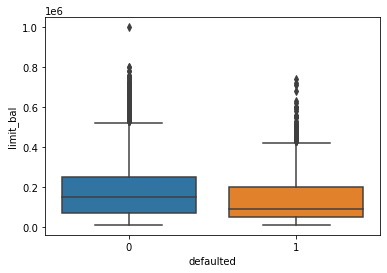

In [142]:
## Boxplot analyzing distribution of limit balance values for people who didn't and did default
sns.boxplot(x="defaulted", y="limit_bal", data=X)

<AxesSubplot:xlabel='defaulted', ylabel='repay_status_sept'>

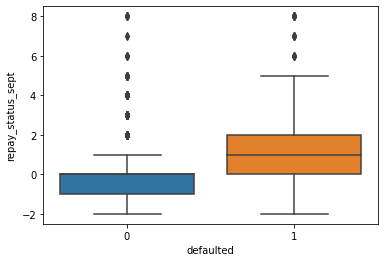

In [143]:
## Boxplot analyzing distribution of repayment statuses in September for people who didn't and did default
sns.boxplot(x="defaulted", y="repay_status_sept", data=X)

<AxesSubplot:xlabel='defaulted', ylabel='repay_status_aug'>

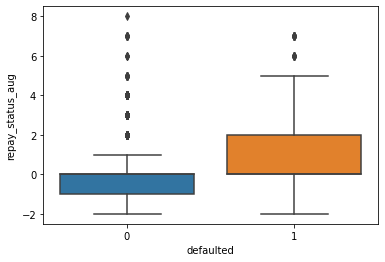

In [144]:
## Boxplot analyzing distribution of repayment statuses in August for people who didn't and did default
sns.boxplot(x="defaulted", y="repay_status_aug", data=X)

<AxesSubplot:xlabel='defaulted', ylabel='repay_status_jul'>

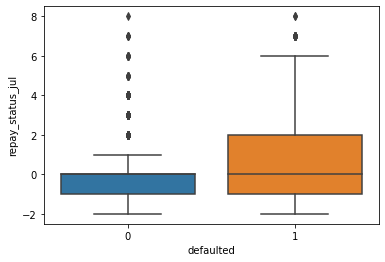

In [145]:
## Boxplot analyzing distribution of repayment statuses in July for people who didn't and did default
sns.boxplot(x="defaulted", y="repay_status_jul", data=X)

<AxesSubplot:xlabel='defaulted', ylabel='repay_status_jun'>

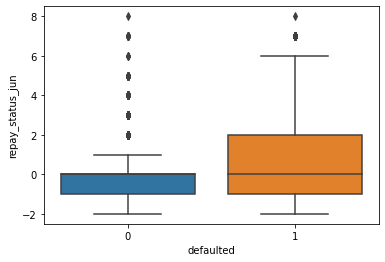

In [146]:
## Boxplot analyzing distribution of repayment statuses in June for people who didn't and did default
sns.boxplot(x="defaulted", y="repay_status_jun", data=X)

**I only included the notable graphs in this report. There seems to a be general difference in the distribution of repayment statuses in many months between people who did and did not default, with people who have defaulted being generally more behind on their payments.**

In [147]:
# correlation table to see how highly correlated each variable is with the y variable (defaulted)
X_train.corrwith(X_train.defaulted)

limit_bal            -0.154328
age                   0.017088
repay_status_sept     0.325840
repay_status_aug      0.266825
repay_status_jul      0.238275
repay_status_jun      0.220944
repay_status_may      0.205067
repay_status_apr      0.188860
pay_amt_sept         -0.067933
pay_amt_aug          -0.056479
pay_amt_jul          -0.053817
pay_amt_jun          -0.054048
pay_amt_may          -0.049705
pay_amt_apr          -0.054989
university            0.040820
high_school           0.031326
others_education     -0.044496
married               0.029431
others_married        0.003567
sex_male              0.043076
avg_bill_per_month   -0.012881
defaulted             1.000000
dtype: float64

<AxesSubplot:title={'center':'Credit Card Data Heatmap'}>

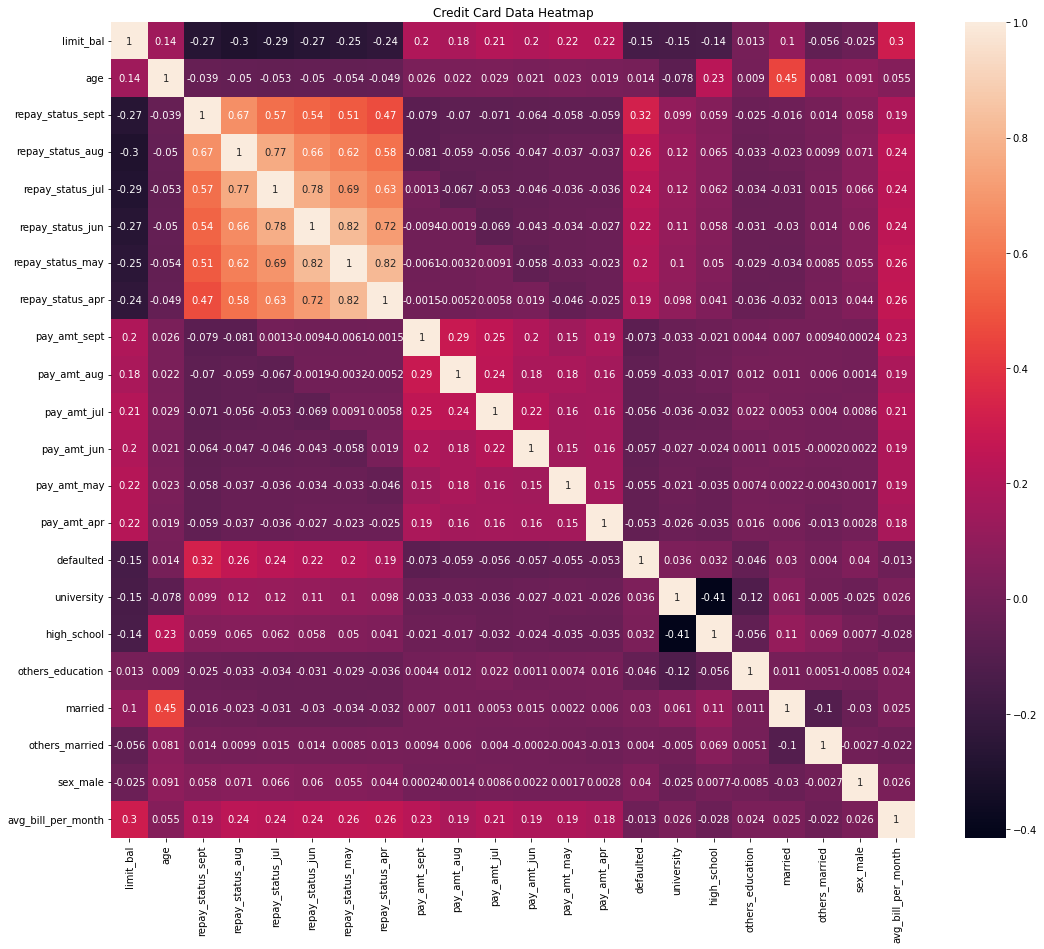

In [148]:
## Visualize data using correlation
corr = X.corr()
plt.figure(figsize=(18,15))
plt.title('Credit Card Data Heatmap')
sns.heatmap(corr,annot=True)

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

In [30]:
# initial model developed based on feature selection and correlations analysis (Kaitlin Sun)
logit_model_original = smf.logit(formula = 'defaulted~age+limit_bal+repay_status_sept*repay_status_aug*repay_status_jul+pay_amt_jul', data = X_train).fit() #Developing logistic regression model
logit_model_original.summary()

Optimization terminated successfully.
         Current function value: 0.457963
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              defaulted   No. Observations:                24000
Model:                          Logit   Df Residuals:                    23989
Method:                           MLE   Df Model:                           10
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.1346
Time:                        22:28:17   Log-Likelihood:                -10991.
converged:                       True   LL-Null:                       -12700.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -1.6458      0.068    -24.112      0.000      -1.780      -1.512
age                                                     0.0096      0.002      5.312      0.000       0.006       0.013
limit_bal                                           -1.728e-06   1.57e-07    -11.030      0.000   -2.03e-06   -1.42e-06
repay_status_sept                                       0.7132      0.022     32.237      0.000       0.670       0.757
repay_status_aug                                       -0.0219      0.028     -0.773      0.440      -0.077       0.034
repay_status_sept:repay_status_aug                      0.0897      0.020      4.451      0.000       0.050       0.129
repay_status_jul                                        0.1069      0.026      4.075      0.000       0.055       0.158
repay_status_sept:repay_status_jul                      0.0410      0.023      1.775      0.076      -0.004       0.086
repay_status_aug:repay_status_jul                       0.1271      0.011     11.236      0.000       0.105       0.149
repay_status_sept:repay_status_aug:repay_status_jul    -0.0541      0.003    -21.427      0.000      -0.059      -0.049
pay_amt_jul                                         -4.669e-06   1.64e-06     -2.850      0.004   -7.88e-06   -1.46e-06
=======================================================================================================================
"""

In [34]:
# Function to compute confusion matrix and prediction accuracy on test data (from notes)
def confusion_matrix_test(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    recall = cm[1,1]/(cm[1,1]+cm[1,0])
    precision = cm[1,1]/(cm[1,1]+cm[0,1])
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Recall = {:.1%}".format(recall))
    print("Precision = {:.1%}".format(precision))

In the context, the errors have the following meanings:
- False Positive: the bank will reject a customer who does not default payment **thus face the consequence of losing a customer**
- False Negative: the bank will accept a customer who default payment **thus face the consequence of defaulting**

In the context, the cost of defaulting will be more significant to the bank than the cost of losing a customer; which means that the bank want to minimize `False Negative`, to maximize `recall`, and would be willing to do so with the tradeoff of an decrease in precision. 

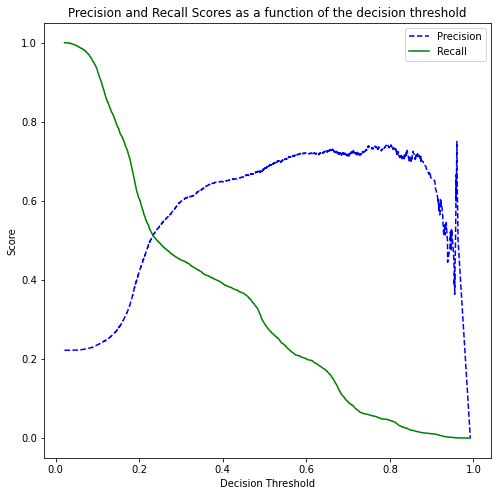

In [35]:
from sklearn.metrics import precision_recall_curve
y=y_train
ypred = logit_model_original.predict(X_train)
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

0.720454002588735


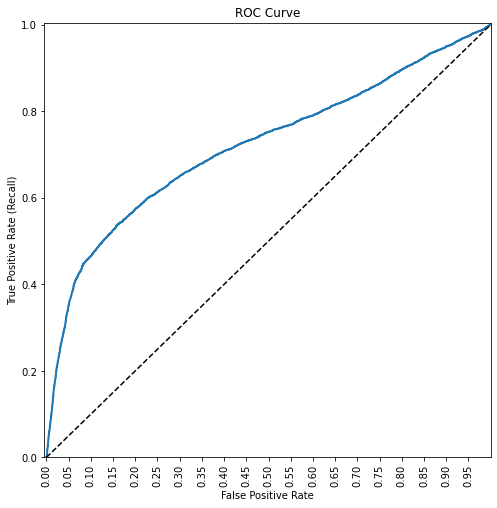

In [36]:
from sklearn.metrics import roc_curve, auc
y=y_train
ypred = logit_model_original.predict(X_train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

Classification accuracy = 40.6%
Recall = 84.9%
Precision = 25.1%


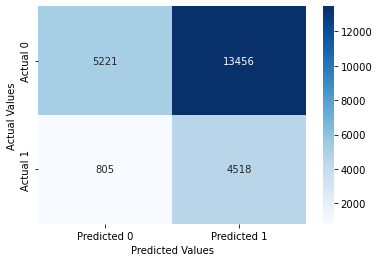

In [37]:
confusion_matrix_test(X_train,y_train,logit_model_original, 0.125)

Classification accuracy = 40.4%
Recall = 85.1%
Precision = 24.8%


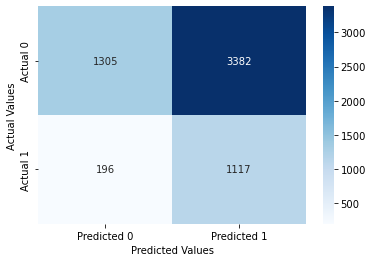

In [38]:
confusion_matrix_test(X_test,y_test,logit_model_original, 0.125)

## Variable Selection (Kaitlin Sun, Andy Wen, and Davis Johnson)

### Forward Selection (Andy Wen)

In [39]:
# Forward Selection
# create predictors to find the best predictor
# drop y variable
X_best = X_train[['limit_bal', 'sex_male', 'age', 'repay_status_sept', 'repay_status_aug',
       'repay_status_jul', 'repay_status_jun', 'repay_status_may',
       'repay_status_apr', 'avg_bill_per_month', 'pay_amt_sept', 'pay_amt_aug', 'pay_amt_jul',
       'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr',
       'university', 'high_school', 'married',
       'others_married']]

# import necessary packages
import itertools
import time

In [40]:
#Function to develop a model based on all predictors in predictor_subset (From Notes)

def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.logit('defaulted~' + '+'.join(predictor_subset), data = X_train).fit()
    bic = model.bic
    return {"model":model, "BIC":bic}


#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors (From Notes)
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_best.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        subset = predictors + [p]
        results.append(processSubset(subset))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['BIC'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

# Function to run Forward Selection() (From Notes)
def forward_selection():
    models_best = pd.DataFrame(columns=["BIC", "model"])

    tic = time.time()
    predictors = []
    
    # there's some issue with any model that has "others education", "graduate school", and "university" together
    for i in range(1,len(X_best.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.516120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529082
  

Optimization terminated successfully.
         Current function value: 0.469406
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468790
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469335
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469260
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469369
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469206
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469506
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.469505
  

Optimization terminated successfully.
         Current function value: 0.466424
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466439
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466368
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466432
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466473
         Iterations 7
Processed  10 models on 11 predictors in 1.2936785221099854 seconds.
Optimization 

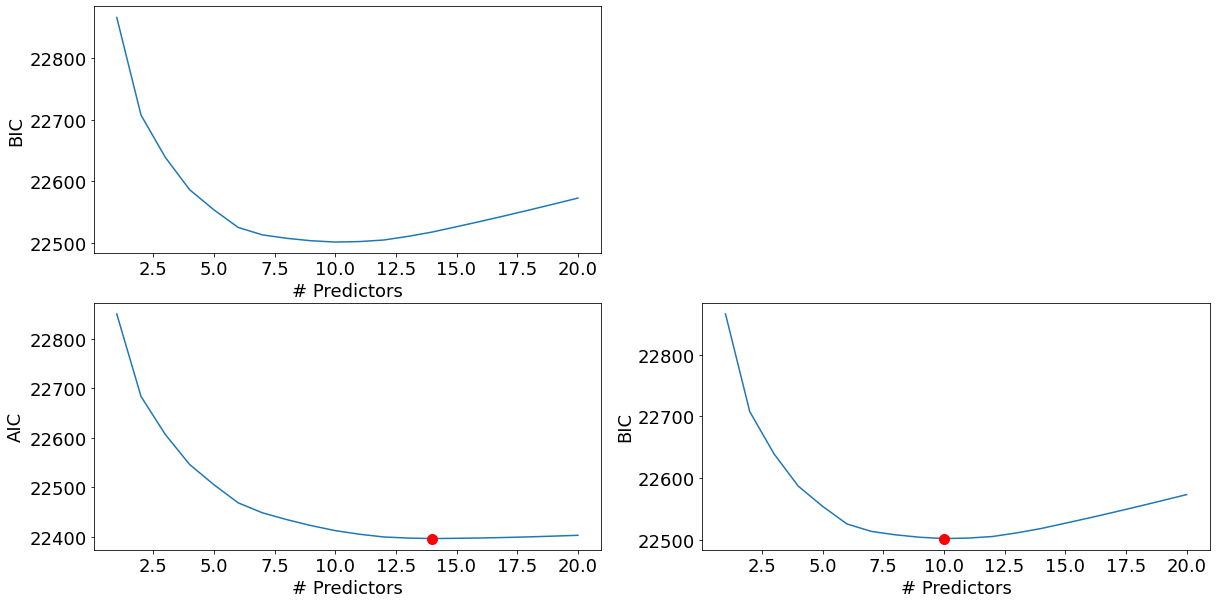

In [41]:
# Graph out results (From Notes)
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["BIC"])
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
    
best_sub_plots()

In [42]:
# Select the best model based on BIC which seems to be 10 variables
fwd_sel_model = models_best.loc[10, 'model']
fwd_sel_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              defaulted   No. Observations:                24000
Model:                          Logit   Df Residuals:                    23989
Method:                           MLE   Df Model:                           10
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.1185
Time:                        22:28:42   Log-Likelihood:                -11195.
converged:                       True   LL-Null:                       -12700.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.2233      0.035    -34.973      0.000      -1.292      -1.155
repay_status_sept      0.5847      0.020     29.486      0.000       0.546       0.624
limit_bal          -7.901e-07   1.65e-07     -4.787      0.000   -1.11e-06   -4.67e-07
repay_status_jul       0.0726      0.025      2.865      0.004       0.023       0.122
pay_amt_sept       -8.715e-06   2.17e-06     -4.023      0.000    -1.3e-05   -4.47e-06
married                0.2229      0.034      6.618      0.000       0.157       0.289
avg_bill_per_month -2.076e-06    3.5e-07     -5.925      0.000   -2.76e-06   -1.39e-06
pay_amt_aug         -9.84e-06   2.18e-06     -4.515      0.000   -1.41e-05   -5.57e-06
sex_male               0.1307      0.034      3.854      0.000       0.064       0.197
repay_status_jun       0.0779      0.022      3.523      0.000       0.035       0.121
repay_status_aug       0.0788      0.022      3.507      0.000       0.035       0.123
======================================================================================
"""

## Backward Selection (Davis Johnson)

In [43]:
# Functions to perform Backward Selection (From Notes) 
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['BIC'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward_selection():
    models_best = pd.DataFrame(columns=["BIC", "model"], index = range(1,len(Xt.columns)))

    tic = time.time()
    predictors = Xt.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

models_best = backward_selection()

Optimization terminated successfully.
         Current function value: 0.465042
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465491
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465148
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465167
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465063
  

         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465330
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465587
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465926
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465210
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465174
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465204
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465611
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465481
         Iterations 7
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.466100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465775
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.483509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466075
         Iterations 7
Processed  12 models on 11 predictors in 1.68477463722229 seconds.
Optimization terminated successfully.
         Current function value: 0.466383
         Iterations 7
Optimization te

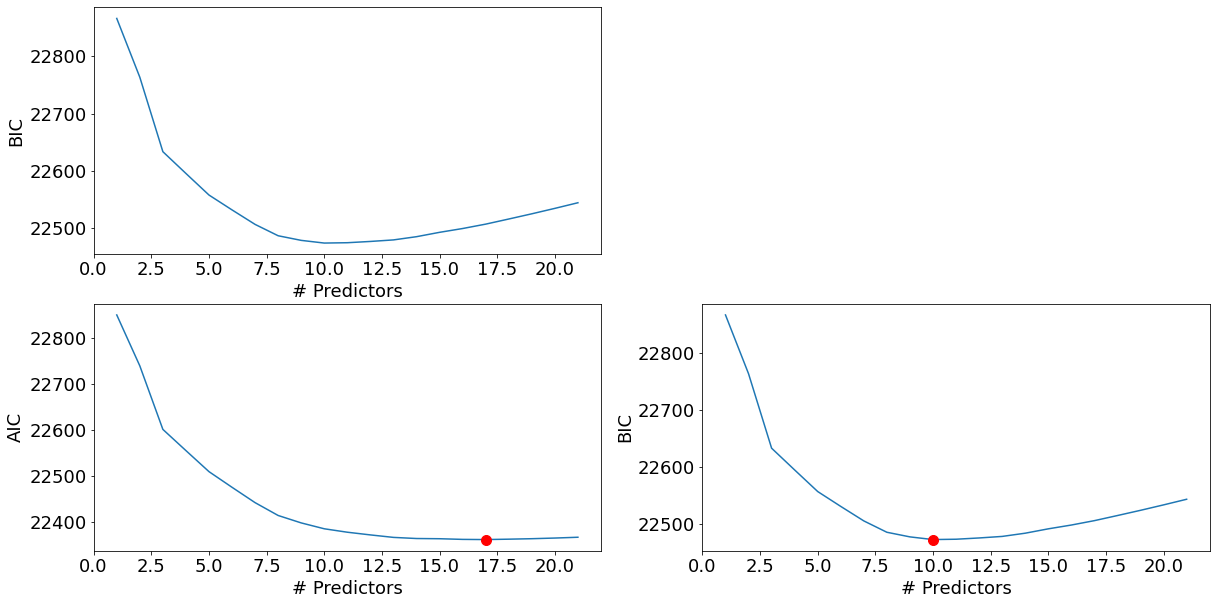

In [44]:
best_sub_plots()

In [45]:
# Select the best model based on BIC which seems to be 10 variables
backward_sel_model = models_best.loc[10, 'model']
backward_sel_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              defaulted   No. Observations:                24000
Model:                          Logit   Df Residuals:                    23989
Method:                           MLE   Df Model:                           10
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.1196
Time:                        22:29:16   Log-Likelihood:                -11181.
converged:                       True   LL-Null:                       -12700.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.2106      0.035    -34.604      0.000      -1.279      -1.142
limit_bal          -8.309e-07   1.65e-07     -5.036      0.000   -1.15e-06   -5.07e-07
repay_status_sept      0.5853      0.020     29.522      0.000       0.546       0.624
repay_status_aug       0.1071      0.020      5.420      0.000       0.068       0.146
repay_status_jun       0.1111      0.018      6.072      0.000       0.075       0.147
pay_amt_sept        -7.89e-06    2.1e-06     -3.762      0.000    -1.2e-05   -3.78e-06
pay_amt_aug        -1.065e-05   2.21e-06     -4.828      0.000    -1.5e-05   -6.33e-06
others_education      -1.0646      0.202     -5.271      0.000      -1.460      -0.669
married                0.2234      0.034      6.629      0.000       0.157       0.289
sex_male               0.1306      0.034      3.851      0.000       0.064       0.197
avg_bill_per_month -1.968e-06    3.5e-07     -5.625      0.000   -2.65e-06   -1.28e-06
======================================================================================
"""

**When comparing the backward selection and forward selection model, we see that the backward selection model has a higher log likelihood (-11181 for backwards vs -11195 for forwards). We will thus move forward with the backward selection model whcih we will peform K-Fold Cross Validation on to obtain interactions and transformations.**

## Transformations and Interactions Analysis 

### Transformation and Interaction Analysis (Andy Wen)

C:\Users\17145\AppData\Local\Temp/ipykernel_1520/1016935965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['limit_bal_binned'] = binned_limit_bal[0]


Text(0.5, 0, 'limit_bal_bin')

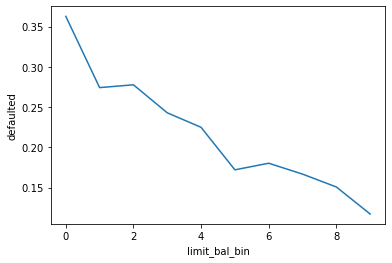

In [149]:
# looking for transformations that can help with model
# Binning limit_bal
binned_limit_bal = pd.qcut(X_train['limit_bal'], 10, retbins=True)
X_train['limit_bal_binned'] = binned_limit_bal[0]

# Finding percentage of people defaulting based on limit_bal 
limit_bal_data = X_train.groupby('limit_bal_binned').mean()['defaulted'].reset_index()

# Visualizing percentage of people having defaults with increasing limit_bal
sns.lineplot(x = limit_bal_data.index, y= limit_bal_data['defaulted'])
plt.xlabel('limit_bal_bin')

C:\Users\17145\AppData\Local\Temp/ipykernel_1520/1410858024.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['age_binned'] = binned_age[0]


Text(0.5, 0, 'age_bin')

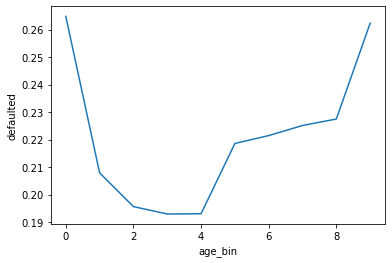

In [150]:
# looking for transformations that can help with model
# adding a quadratic transformation with age can help, but it turns out the transformation variable becomes insignificant
# Binning age
binned_age = pd.qcut(X_train['age'], 10, retbins=True)
X_train['age_binned'] = binned_age[0]

# Finding percentage of people defaulting based on age
age_data = X_train.groupby('age_binned').mean()['defaulted'].reset_index()

# Visualizing percentage of people having defaults with increasing age
sns.lineplot(x = age_data.index, y= age_data['defaulted'])
plt.xlabel('age_bin')

<AxesSubplot:xlabel='age'>

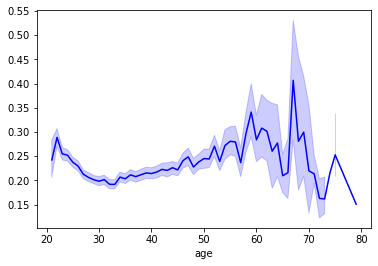

In [151]:
# not an obvious transformation to be done here
sns.lineplot(x = 'age', y= logit_model_original.predict(X_train), data = X_train, color = 'blue')

C:\Users\17145\AppData\Local\Temp/ipykernel_1520/2990228715.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pay_amt_aug_binned'] = binned_pay_amt_aug[0]


Text(0.5, 0, 'pay_amt_aug_bin')

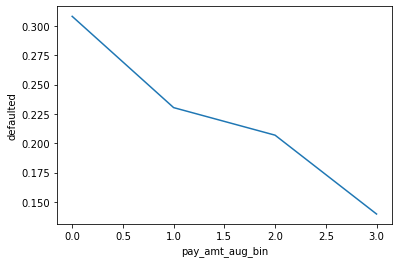

In [152]:
# looking for transformations that can help with model (trend is linear)
# Binning pay_amt_aug
binned_pay_amt_aug = pd.qcut(X_train['pay_amt_aug'], 4, retbins=True)
X_train['pay_amt_aug_binned'] = binned_pay_amt_aug[0]

# Finding percentage of people defaulting based on pay_amt_aug
pay_amt_aug_data = X_train.groupby('pay_amt_aug_binned').mean()['defaulted'].reset_index()

# Visualizing percentage of people having defaults with increasing pay_amt_aug
sns.lineplot(x = pay_amt_aug_data.index, y= pay_amt_aug_data['defaulted'])
plt.xlabel('pay_amt_aug_bin')

C:\Users\17145\AppData\Local\Temp/ipykernel_1520/2697715544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pay_amt_sept_binned'] = binned_pay_amt_sept[0]


Text(0.5, 0, 'pay_amt_sept_bin')

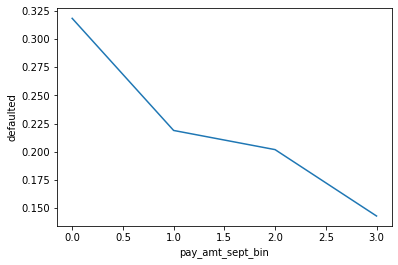

In [153]:
# looking for transformations that can help with model (trend is linear)
# Binning pay_amt_sept
binned_pay_amt_sept = pd.qcut(X_train['pay_amt_sept'], 4, retbins=True)
X_train['pay_amt_sept_binned'] = binned_pay_amt_sept[0]

# Finding percentage of people defaulting based on pay_amt_aug
pay_amt_sept_data = X_train.groupby('pay_amt_sept_binned').mean()['defaulted'].reset_index()

# Visualizing percentage of people having defaults with increasing pay_amt_aug
sns.lineplot(x = pay_amt_sept_data.index, y= pay_amt_sept_data['defaulted'])
plt.xlabel('pay_amt_sept_bin')

C:\Users\17145\AppData\Local\Temp/ipykernel_1520/2057082673.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['avg_bill_per_month_binned'] = binned_avg_bill_per_month[0]


Text(0.5, 0, 'avg_bill_per_month_bin')

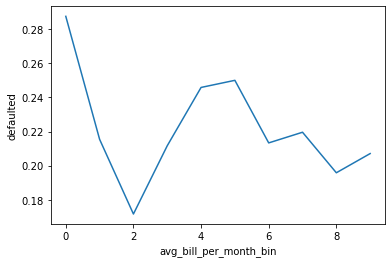

In [155]:
# looking for transformations that can help with model (trend is non-linear)
# Binning avg_bill_per_month
binned_avg_bill_per_month = pd.qcut(X_train['avg_bill_per_month'], 10, retbins=True)
X_train['avg_bill_per_month_binned'] = binned_avg_bill_per_month[0]

# Finding percentage of people defaulting based on avg_bill_per_month
avg_bill_per_month_data = X_train.groupby('avg_bill_per_month_binned').mean()['defaulted'].reset_index()

# Visualizing percentage of people having defaults with increasing avg_bill_per_month
sns.lineplot(x = avg_bill_per_month_data.index, y= avg_bill_per_month_data['defaulted'])
plt.xlabel('avg_bill_per_month_bin')

In [ ]:
# looking for transformations that can help with model (trend is non-linear)
# Binning avg_bill_per_month
binned_repay_status_sept = pd.qcut(X_train['repay_status_sept'], 10, retbins=True)
X_train['repay_status_sept_binned'] = binned_repay_status_sept[0]

# Finding percentage of people defaulting based on avg_bill_per_month
avg_bill_per_month_data = X_train.groupby('avg_bill_per_month_binned').mean()['defaulted'].reset_index()

# Visualizing percentage of people having defaults with increasing avg_bill_per_month
sns.lineplot(x = avg_bill_per_month_data.index, y= avg_bill_per_month_data['defaulted'])
plt.xlabel('avg_bill_per_month_bin')



In [34]:
# drop bins
X_train = X_train.drop(columns=['limit_bal_binned', 'age_binned', 'pay_amt_jul_binned'])

## Lasso (Kaitlin Sun)

In [105]:
# Import packages for Lasso
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [106]:
#Standardizing predictors so that each of them have zero mean and unit variance

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
y = X_train['defaulted']
X_train = X_train.drop('defaulted', axis = 1)
X_test = X_test.drop('defaulted', axis = 1)
scaler.fit(X_train)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X_train)

In [107]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

In [108]:
#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

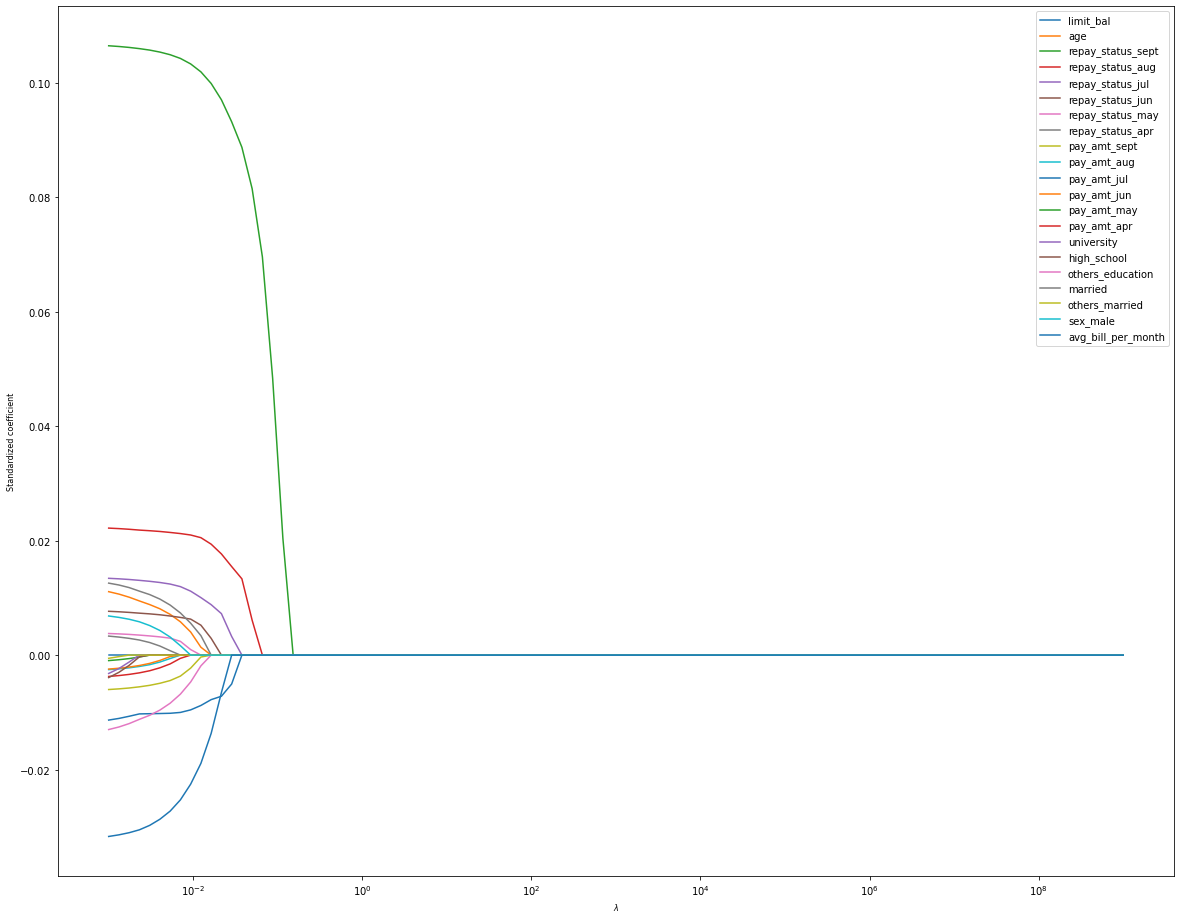

In [109]:
#Visualizing the shrinkage in lasso regression coefficients with increasing values of the tuning parameter lambda
plt.figure(figsize=(20,16))
plt.xlabel('xlabel', fontsize=8)
plt.ylabel('ylabel', fontsize=8)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(X_train.columns[:]);

In [110]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.0004664652013142343

Text(0, 0.5, 'Cross-validation error')

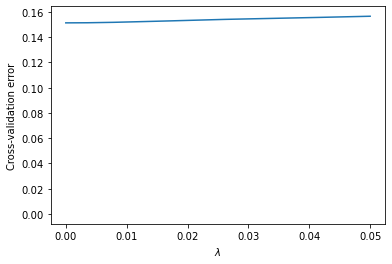

In [111]:
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[3e-06,6e-06],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

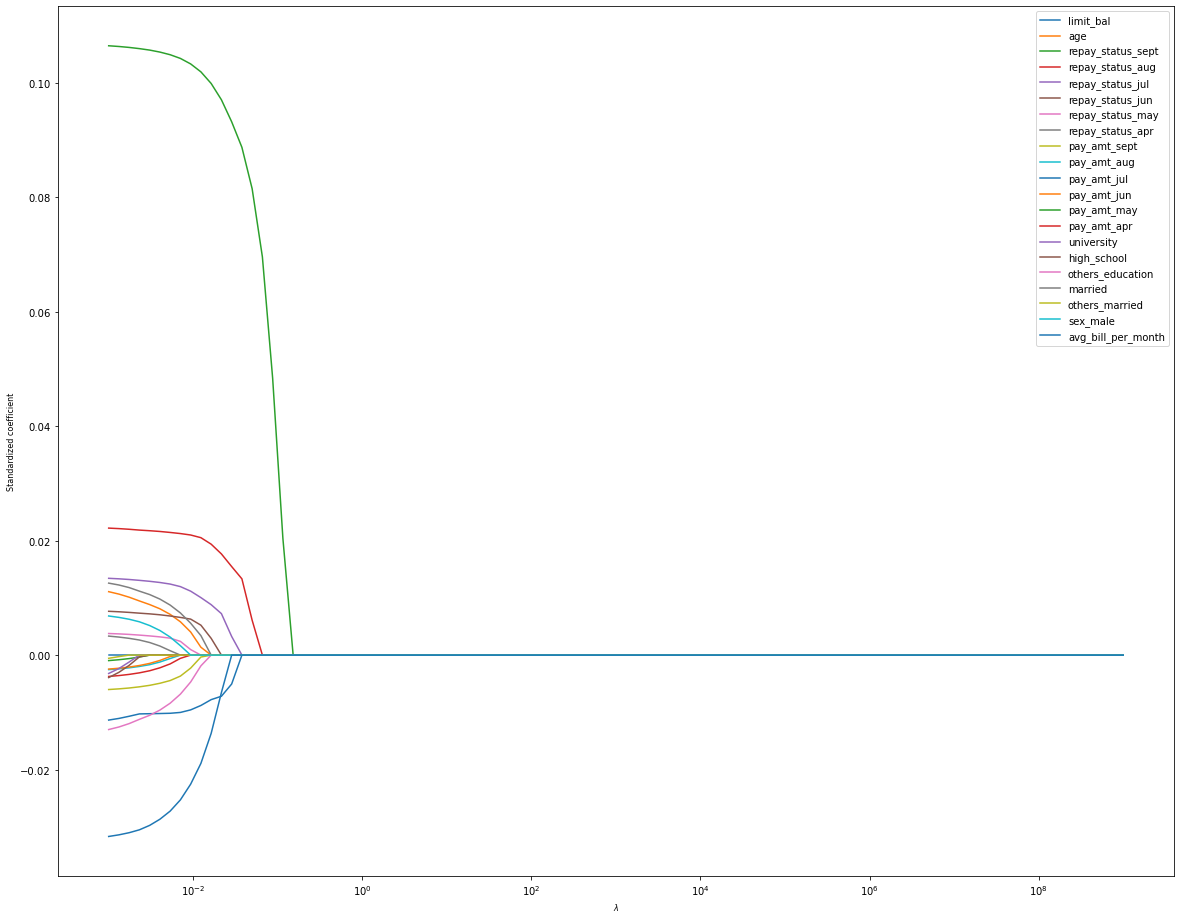

In [112]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.figure(figsize=(20,16))
plt.xlabel('xlabel', fontsize=8)
plt.ylabel('ylabel', fontsize=8)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(X_train.columns[:]);

In [113]:
#Standardizing test data
Xtest_std = scaler.transform(X_test)

In [114]:
#Using the developed lasso regression model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

In [115]:
#RMSE on test data
np.sqrt((pred-y_test)**2).mean()

0.3071514563512326

In [116]:
#Checking the coefficients of the lasso model
lasso.coef_

array([-0.01183395,  0.01178664,  0.10668348,  0.02233542,  0.01356696,
        0.00779238,  0.00388411,  0.00360174, -0.00620343, -0.00276145,
        0.        , -0.00269711, -0.00120962, -0.00398978, -0.00463562,
       -0.00544939, -0.01374985,  0.01311746, -0.00104408,  0.00723835,
       -0.03216482])

In [117]:
lasso_result = pd.DataFrame([X_train.columns, lasso.coef_])
lasso_result = lasso_result.T

In [118]:
lasso_result_nonzero = lasso_result.loc[lasso_result[1]!=0]

In [119]:
lasso_result_nonzero

,0,1
0,limit_bal,-0.011834
1,age,0.011787
2,repay_status_sept,0.106683
3,repay_status_aug,0.022335
4,repay_status_jul,0.013567
5,repay_status_jun,0.007792
6,repay_status_may,0.003884
7,repay_status_apr,0.003602
8,pay_amt_sept,-0.006203
9,pay_amt_aug,-0.002761


### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.